In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import all functions

import cv2
from tqdm import tqdm
import pandas as pd
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import json
from multiprocessing import Pool
from time import time
from functools import partial
plt.rcParams['figure.figsize'] = [10, 10]
import datetime

import sys
import scale
import symmetry

from cvfunc import color_threshold,auto_crop,auto_crop_color,symmetric_shift


In [3]:
#
# The Color Palette to use:
#

# BGR and repeated: [B,G,R,B,G,R] 
# Added/subtracted an adjustment, to give color values a range, i.e. [B-2,G-2,R-2,B+2,G+2,R+2]

adj=10 # had to make this larger, because there's color "noise" in the shrinked images

# want to be able to give a RANGE of color values, but can't go under 0, or above 255. Use inbetween function:
def lim(minv, val, maxv):
    return min(maxv, max(minv, val))

# The color palette from 2021: USE THIS ONE
# NOTE: BGR values from color picker is not necesarily accurate, 
# so make sure to pick out the colors using the "color_lab" (or below)
# uncertain about DC colors for capped honey, nectar, pollen (put the ?)

color_palette = {
"bg":[255,255,255,255,255,255],
"uncapped_brood":[lim(0, 240-adj, 255), lim(0, 174-adj, 255), lim(0, 0-adj, 255), 
                  lim(0, 240+adj, 255), lim(0, 174+adj, 255), lim(0, 0+adj, 255)],
"uncapped_brood_d":[lim(0, 145-adj, 255), lim(0, 105-adj, 255), lim(0, 1-adj, 255), 
                    lim(0, 145+adj, 255), lim(0, 105+adj, 255), lim(0, 1+adj, 255)],
"capped_brood":[lim(0, 255-adj, 255), lim(0, 0-adj, 255), lim(0, 0-adj, 255), 
                lim(0, 255+adj, 255), lim(0, 0+adj, 255), lim(0, 0+adj, 255)],
"capped_brood_d":[lim(0, 136-adj, 255), lim(0, 0-adj, 255), lim(0, 0-adj, 255), 
                  lim(0, 136+adj, 255), lim(0, 0+adj, 255), lim(0, 0+adj, 255)],
"nectar":[lim(0, 86-adj, 255), lim(0, 255-adj, 255), lim(0, 255-adj, 255), 
          lim(0, 86+adj, 255), lim(0, 255+adj, 255), lim(0, 255+adj, 255)],
"nectar_d?":[lim(0, 60-adj, 255), lim(0, 183-adj, 255), lim(0, 183-adj, 255), 
            lim(0, 60+adj, 255), lim(0, 183+adj, 255), lim(0, 183+adj, 255)],
"honey":[lim(0, 197-adj, 255), lim(0, 255-adj, 255), lim(0, 216-adj, 255), 
         lim(0, 197+adj, 255), lim(0, 255+adj, 255), lim(0, 216+adj, 255)],
"honey_d?":[lim(0, 185-adj, 255), lim(0, 210-adj, 255), lim(0, 168-adj, 255), 
           lim(0, 185+adj, 255), lim(0, 210+adj, 255), lim(0, 168+adj, 255)],
"empty":[lim(0, 92-adj, 255), lim(0, 92-adj, 255), lim(0, 92-adj, 255), 
         lim(0, 92+adj, 255), lim(0, 92+adj, 255), lim(0, 92+adj, 255)],
"empty_d":[lim(0, 0-adj, 255), lim(0, 0-adj, 255), lim(0, 0-adj, 255), 
           lim(0, 0+adj, 255), lim(0, 0+adj, 255), lim(0, 0+adj, 255)],
"pollen":[lim(0, 34-adj, 255), lim(0, 101-adj, 255), lim(0, 242-adj, 255), 
          lim(0, 34+adj, 255), lim(0, 101+adj, 255), lim(0, 242+adj, 255)],
"pollen_d?":[lim(0, 29-adj, 255), lim(0, 60-adj, 255), lim(0, 127-adj, 255), 
            lim(0, 29+adj, 255), lim(0, 60+adj, 255), lim(0, 127+adj, 255)]    
}

# The color palette from 2013: 
# color_palette = {
# "bg":[255,255,255,255,255,255],
# "brood":[35,50,236,35,50,236],
# "brood_d":[128,117,227,128,117,227],
# "honey":[245,33,0,245,33,0],
# "honey_d":[252,251,117,252,251,117],
# "empty":[75,250,117,75,250,117],
# "empty_d":[161,210,172,161,210,172],
# "pollen":[61,151,235,61,151,235]
# }

search_ratio = 0.05

In [4]:
# Paths:

# these are the original full-sized images: 
original_images_path = './original_images/*/'

# first step will be to apply the symmetric shift: 
symmetric_shift_images_path = './symmetric_shift_images/'

# THEN scale them down (otherwise get rough edges from the symmetric shift):
scaled_images_path = "./shrink"



In [5]:
# FIRST apply the symmetric shift to each image: 

for file in tqdm(glob.glob(original_images_path+"/*.png"),desc="Progress"): # be sure to have .PNG file! 
    original = cv2.imread(file)
    symmetric_shifted = symmetric_shift(original)
    savestring = os.path.join(symmetric_shift_images_path,f"{os.path.splitext(os.path.basename(file))[0]}.png")
    cv2.imwrite(savestring,symmetric_shifted)


Progress: 100%|██████████| 6/6 [00:36<00:00,  6.04s/it]


In [6]:
# THEN resize them: 
# Ideally, the height would be 100 px, but need to remove white space

for file in tqdm(glob.glob(symmetric_shift_images_path+"/*.png"),desc="Progress"): # be sure to have .PNG file! 
    savestring = os.path.join(scaled_images_path,f"{os.path.splitext(os.path.basename(file))[0]}.png")
    image = cv2.imread(file)
    resized = scale.resize3(image,100) # height, in PX - NOW AT 100 PX!!! (obs hive is 100cm high, 1px=1cm=2x2cells)
    cv2.imwrite(savestring,resized)
    image = cv2.imread(savestring)
    cropped = auto_crop_color(image)
    cv2.imwrite(savestring,cropped)

Progress: 100%|██████████| 6/6 [00:05<00:00,  1.06it/s]


In [7]:
### NOTE: STILL NEED TO REMOVE EXCESS WHITE SPACE ###
### NOTE: The shrink images still have a few pixels that deviate from the palette ###

./shrink/East_day105_16Apr2013_mirror.png


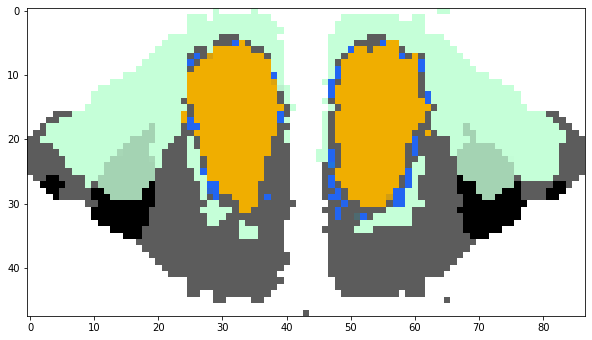

./shrink/Office_day261_18Sep2013_W.png


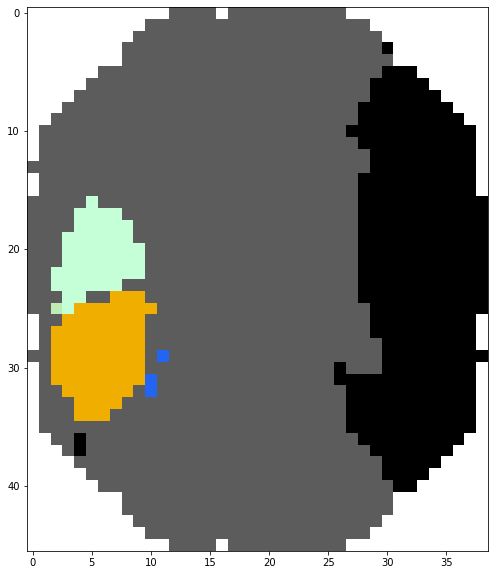

./shrink/square.png


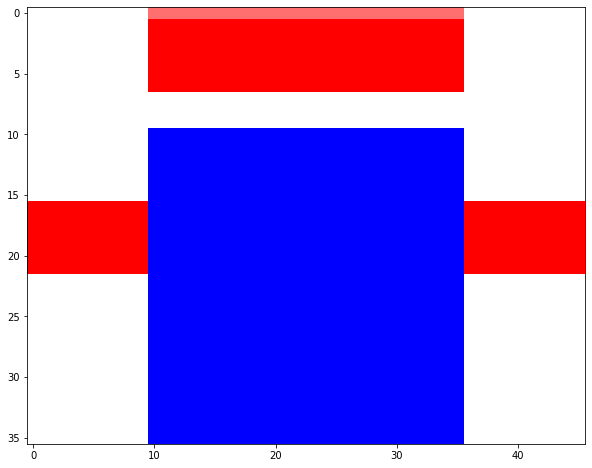

./shrink/two_squares.png


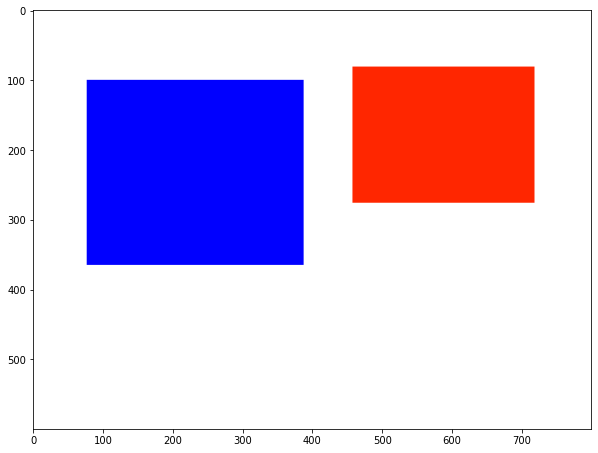

./shrink/Office_day261_18Sep2013_E.png


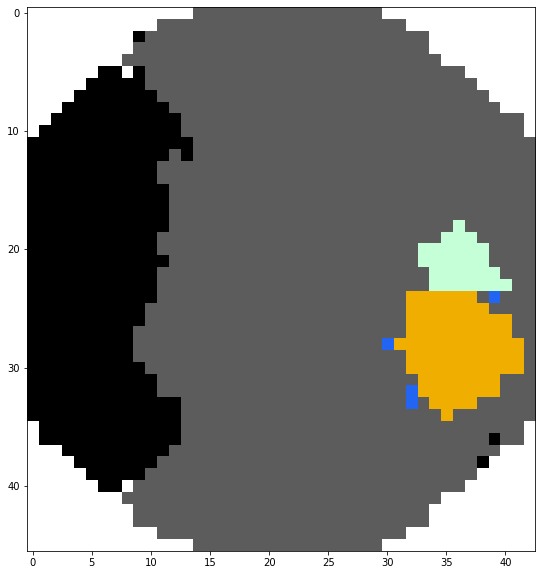

./shrink/East_day105_16Apr2013_N.png


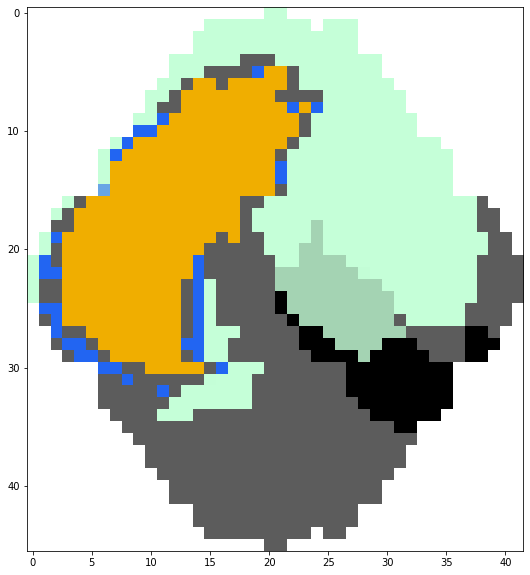

./shrink/Office_day261_18Sep2013_mirror.png


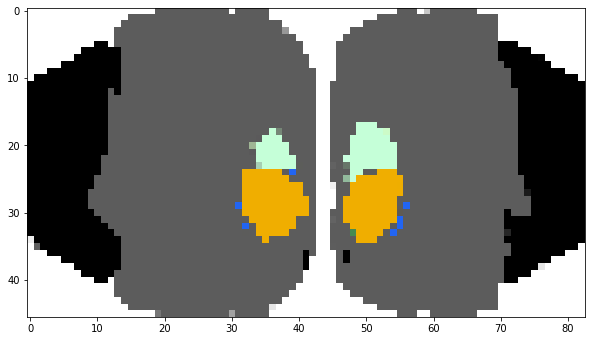

./shrink/East_day105_16Apr2013_S.png


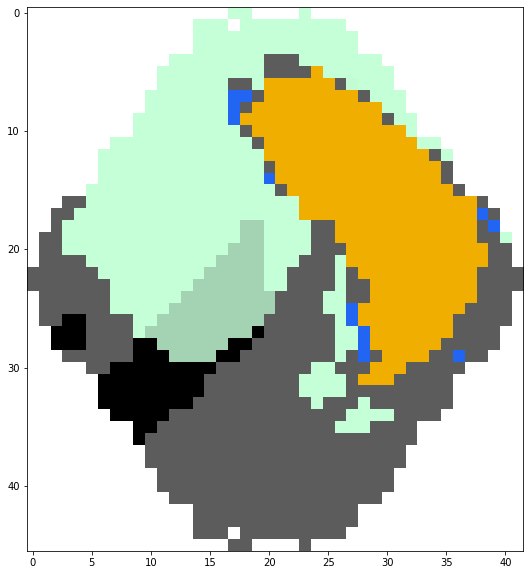

./shrink/japan.png


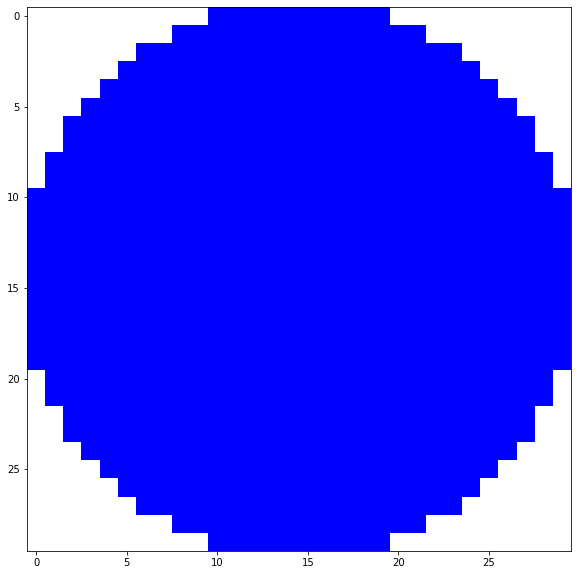

In [8]:
# Just for early versions, show all images to make sure all good: 

glob_str = scaled_images_path+'/*'
filenames = glob.glob(glob_str)

for i in filenames:
    print(i)
    img = cv2.imread(i)
    plt.imshow(img)
    plt.show()

In [10]:
df_stochastic = []
for i in filenames:
    palette = color_palette if not (("two_squares.png" in i) or ("japan.png" in i) or ("square.png" in i)) else {'bg':[255]*6, 'red':[0,0,255,0,0,255], 'blue':[255,0,0,255,0,0]}
    img = cv2.imread(i)
    score0 = symmetry.symmetry_score_jaccard(img,color_dict=palette)
    score90 = symmetry.symmetry_score_jaccard(img.transpose(1,0,2),color_dict=palette)
    row = {
        "name": os.path.basename(i),
        #"score0_expected": score0['expected'],
        "score0_real": score0,
        #"score90_expected": score90['expected'],
        "score90_real": score90,
    }
    df_stochastic.append(row)
df_stochastic = pd.DataFrame(df_stochastic)

# Explanation

The table below shows the expected and calculated symmetry scores. They are both values in the interval [0,1] where 0 denotes complete asymmetry and 1 denote complete symmetry. A good threshold to classify the pictures betweem symmetric and asymmetric would be 0.5.

A symmetry score that is too far from the expected value should be taken as a value that is not expected from a random configuration of pixels. Therefore, these values can be considered 'meaningful'.

In [11]:
df_stochastic

,name,score0_real,score90_real
0,East_day105_16Apr2013_mirror.png,0.633105,0.155949
1,Office_day261_18Sep2013_W.png,0.331109,0.647095
2,square.png,1.000000,0.306968
3,two_squares.png,0.000000,0.325000
4,Office_day261_18Sep2013_E.png,0.317935,0.668349
5,East_day105_16Apr2013_N.png,0.205797,0.163504
6,Office_day261_18Sep2013_mirror.png,0.458005,0.664980
7,East_day105_16Apr2013_S.png,0.242104,0.170403
8,japan.png,1.000000,1.000000
